# Mini Project 4: Developing an Information Retrieval System with Document Ranking

## Reading Data

Import necessary libraries as below:

<ul>
    <li><b>pandas</b>: For reading xml and txt files.</li><br>
    <li><b>numpy</b>: For working with vectors.</li><br>
    <li><b>math</b>: For doing arithmatics.</li><br>
    <li><b>nltk/string</b>: For working with NLP</li><br>
    <li><b>matplotlib</b>: For visualizing.</li>
</ul>

In [6]:
import pandas as pd
import numpy as np 
import math 
from numpy import linalg as LA

from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

import matplotlib.pyplot as plt 

##### Reading main data

Define file paths for reading data.

In [7]:
# Documnets xml file path
xml_doc_file_path = 'data/cranfield-xml/cran.all.1400.xml'

# Queries xml file path
xml_query_file_path = 'data/cranfield-xml/cran.qry.xml'

# Evaluation txt file path
txt_evaluation_apth = 'data/cranfield-xml/cranqrel.trec.txt'

Now, it's time to read data from files!

In [8]:
# read all data about all documents and drop 
# the fisrt column which is the indices of documents
df = pd.read_xml(xml_doc_file_path)
df.drop(df.columns[0], axis=1, inplace=True)

# read all data about all queries and drop 
# the fisrt column which is the indices of queries.
# Also, replace "\n" with " " for cleaning the queries
df_q = pd.read_xml(xml_query_file_path)
df_q.drop(df_q.columns[0], axis=1, inplace=True)
df_q['title'] = df_q['title'].str.replace('\n', ' ')


Show data frames here:

In [6]:
df.head()

,title,author,bib,text
0,experimental investigation of the aerodynamics...,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...
1,simple shear flow past a flat plate in an inco...,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...
2,the boundary layer in simple shear flow past a...,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...
3,approximate solutions of the incompressible la...,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...
4,one-dimensional transient heat conduction into...,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...


In [7]:
df_q.head()

,title
0,what similarity laws must be obeyed when cons...
1,what are the structural and aeroelastic probl...
2,what problems of heat conduction in composite...
3,can a criterion be developed to show empirica...
4,what chemical kinetic system is applicable to...


extract data from dataframes:

In [8]:
titles = df['title']
authors = df['author']
bibs = df['bib']

##### Reading evaluation data

Read data from the evaluation file and make a dictionary named ```evaluation_dict``` to store query ids as key and relevant document ids as values:

In [9]:
evaluation_dict = {}

# Open file and read all lines togeather
with open(txt_evaluation_apth, 'r') as file:
    lines = file.readlines()
    
    # Split the data in each line and extract query id, doc id, and 
    # a 0 of 1(respectively, for non-relevant and relevant documents)
    for i in range(len(lines)):
        query_id = int(lines[i].split()[0])
        relevant = int(lines[i].split()[3])
        doc_id = int(lines[i].split()[2])

        # fill the evaluation dictionary
        if query_id not in evaluation_dict and relevant == 1:
            evaluation_dict[query_id] = [doc_id]
        elif query_id in evaluation_dict and relevant == 1:
            evaluation_dict[query_id].append(doc_id)

Define 2 functions which are calculationg precision and recall respectivly.

\begin{equation*}
P = \frac{TP}{TP + FP}, \;\;
R = \frac{TP}{TP + FN}
\end{equation*}

In [10]:
# compute precision
def compute_precision(results, computed):
    common_elements = list(set(results) & set(computed))
    return len(common_elements) / len(computed)

# compute recall
def compute_recall(results, computed):
    common_elements = list(set(results) & set(computed))
    return len(common_elements) / len(results)

## Preprocessing

Define a function to do the data preprocessing which does the following tasks:
<ul>
    <li>Tokenization</li><br>
    <li>Delete stop words</li><br>
    <li>Lowercase words</li><br>
    <li>Delete punctuations</li><br>
    <li>Stemming</li><br>

</ul>

In [12]:
def preprocessing(document):
    '''
    Define a regular expression pattern for tokenization 
    (matching words, 3-digit numbers, numbers with more than 3 digits and 
    have thousands seperators in which n > 3, and floating-point numbers)
    '''
    if document is not None:
        pattern = r'\d{1,3}(?:,\d{3})*(?:\.\d+)?|\w+'

        # Tokenize the text using the regular expression pattern    
        tokens = regexp_tokenize(document, pattern)

        # Lowercase the tokens
        # tokens = [word.lower() for word in tokens]
        tokens = [word.lower() for word in tokens if word.isalpha()]


        # Get the set of English stopwords
        stop_words = set(stopwords.words('english'))

        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]

        # Remove punctuation
        tokens = [word for word in tokens if word not in string.punctuation]

        # Stemming
        # document = stemming(tokens)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]

        # return the processed document
        return ' '.join(tokens)
    else:
        return ''

##### Document preprocessing

In [13]:
# Apply the preprocessing function to the 'text' column
# and make a new column named preprocessed_text to store the 
# text which is preprocessed
df['preprocessed_text'] = df['text'].apply(preprocessing)

df.head()

,title,author,bib,text,preprocessed_text
0,experimental investigation of the aerodynamics...,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...,experiment investig aerodynam wing slipstream ...
1,simple shear flow past a flat plate in an inco...,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...,simpl shear flow past flat plate incompress fl...
2,the boundary layer in simple shear flow past a...,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...,boundari layer simpl shear flow past flat plat...
3,approximate solutions of the incompressible la...,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...,approxim solut incompress laminar boundari lay...
4,one-dimensional transient heat conduction into...,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...,one dimension transient heat conduct doubl lay...


##### Query processing

In [14]:
# Apply the preprocessing function to the 'title' column
# and make a new column named preprocessed_query to store the 
# title which is preprocessed
df_q['preprocessed_query'] = df_q['title'].apply(preprocessing)

df_q.head()

,title,preprocessed_query
0,what similarity laws must be obeyed when cons...,similar law must obey construct aeroelast mode...
1,what are the structural and aeroelastic probl...,structur aeroelast problem associ flight high ...
2,what problems of heat conduction in composite...,problem heat conduct composit slab solv far
3,can a criterion be developed to show empirica...,criterion develop show empir valid flow solut ...
4,what chemical kinetic system is applicable to...,chemic kinet system applic hyperson aerodynam ...


Also, we define the following function which we will use it in the future for preprocessing the queries:

In [15]:
def query_preprocessing(query):
    query = preprocessing(query)
    query_tokens = query.split()
    
    return query, query_tokens

#### Extract neccessary information from the processed data

In this section we want to extract following useful information from the processed data:
<ul>
    <li>TF(Term Frequency): # occurances of term t in document d</li><br>
    <li>DF(Document Frequency): # occurances of documents containing term t</li><br>
    <li>IDF(Inversed Documnet Frequency): Some kind of inverse of DF</li><br>
    <li>CF(Collection Frequency): # occurances of term t in all the collection</li><br>
</ul>

### Compute TF

In [14]:
# Insert a new column to the df to store tf for eacg document
def count_term_frequency(document):
    tokens = document.split()
    tf = {}

    for term in tokens:
        if term not in tf:
            tf[term] = 1
        else:
            tf[term] += 1
    
    return tf

df['tf'] = df['preprocessed_text'].apply(count_term_frequency)

df.head()

,title,author,bib,text,preprocessed_text,tf
0,experimental investigation of the aerodynamics...,"brenckman,m.","j. ae. scs. 25, 1958, 324.",experimental investigation of the aerodynamics...,experiment investig aerodynam wing slipstream ...,"{'experiment': 2, 'investig': 1, 'aerodynam': ..."
1,simple shear flow past a flat plate in an inco...,ting-yili,"department of aeronautical engineering, rensse...",simple shear flow past a flat plate in an inco...,simpl shear flow past flat plate incompress fl...,"{'simpl': 2, 'shear': 2, 'flow': 6, 'past': 4,..."
2,the boundary layer in simple shear flow past a...,m. b. glauert,"department of mathematics, university of manch...",the boundary layer in simple shear flow past a...,boundari layer simpl shear flow past flat plat...,"{'boundari': 2, 'layer': 2, 'simpl': 1, 'shear..."
3,approximate solutions of the incompressible la...,"yen,k.t.","j. ae. scs. 22, 1955, 728.",approximate solutions of the incompressible la...,approxim solut incompress laminar boundari lay...,"{'approxim': 1, 'solut': 2, 'incompress': 2, '..."
4,one-dimensional transient heat conduction into...,"wasserman,b.","j. ae. scs. 24, 1957, 924.",one-dimensional transient heat conduction into...,one dimension transient heat conduct doubl lay...,"{'one': 2, 'dimension': 1, 'transient': 2, 'he..."


### Compute DF

In [21]:
# Create a dictionary(inverted index) to store in a dictionart
document_frequency = {}

# Obtain unique terms in each document
unique_terms = set([term for doc in df['preprocessed_text'] for term in doc.split()])
print("Total unique terms in dataset: ", len(unique_terms))

# Fill document_frequency dictionary
for term in unique_terms:
    doc_freq = sum([1 for doc in df['preprocessed_text'] if term in doc.split()])
    document_frequency[term] = doc_freq

print("\nDocument Frequency dictiobnary: \n", document_frequency)

Total unique terms in dataset:  4291

Document Frequency dictiobnary: 
 {'senior': 1, 'schwarz': 1, 'similitud': 9, 'stiffen': 36, 'half': 50, 'rubesin': 7, 'thoroughli': 2, 'aileron': 9, 'text': 5, 'absorpt': 6, 'instig': 1, 'proportion': 2, 'basin': 1, 'doubli': 1, 'film': 6, 'sometim': 9, 'pyramid': 1, 'suffix': 1, 'met': 2, 'lectur': 1, 'switch': 1, 'practic': 100, 'crush': 1, 'complic': 12, 'upper': 41, 'slipstream': 15, 'straight': 31, 'parasol': 1, 'armenaka': 2, 'volum': 24, 'isotop': 1, 'liouvil': 1, 'sugar': 1, 'papreg': 1, 'unspecifi': 1, 'adam': 2, 'driven': 6, 'halfway': 1, 'board': 1, 'heat': 306, 'gasdynam': 10, 'hovercraft': 2, 'perman': 2, 'abundantli': 1, 'tube': 71, 'pass': 20, 'greater': 68, 'suitabl': 45, 'enthalp': 1, 'among': 7, 'physcal': 1, 'preval': 1, 'wissler': 1, 'retard': 7, 'gage': 5, 'math': 5, 'bodi': 293, 'intergranular': 1, 'arrang': 12, 'perfor': 3, 'accept': 17, 'confid': 1, 'judg': 2, 'empir': 32, 'x': 84, 'chang': 122, 'igc': 1, 'mw': 1, 'national

### Compute IDF

In [20]:
# Define number of documents as N
N = len(df)
print("N: ", N)

# Fill idf which has unique terms as its keys and their idfs ad values
idf = {}
for key in document_frequency:
    idf[key] = math.log10(N/document_frequency[key])

print("\nIDF: \n", idf)

N:  1400

IDF: 
 {'senior': 3.146128035678238, 'schwarz': 3.146128035678238, 'similitud': 2.191885526238913, 'stiffen': 1.5898255349109507, 'half': 1.4471580313422192, 'rubesin': 2.3010299956639813, 'thoroughli': 2.845098040014257, 'aileron': 2.191885526238913, 'text': 2.4471580313422194, 'absorpt': 2.3679767852945943, 'instig': 3.146128035678238, 'proportion': 2.845098040014257, 'basin': 3.146128035678238, 'doubli': 3.146128035678238, 'film': 2.3679767852945943, 'sometim': 2.191885526238913, 'pyramid': 3.146128035678238, 'suffix': 3.146128035678238, 'met': 2.845098040014257, 'lectur': 3.146128035678238, 'switch': 3.146128035678238, 'practic': 1.146128035678238, 'crush': 3.146128035678238, 'complic': 2.066946789630613, 'upper': 1.5333441789585025, 'slipstream': 1.9700367766225568, 'straight': 1.6547663418439653, 'parasol': 3.146128035678238, 'armenaka': 2.845098040014257, 'volum': 1.765916793966632, 'isotop': 3.146128035678238, 'liouvil': 3.146128035678238, 'sugar': 3.146128035678238, 

### Compute CF

In [24]:
# all_collection_unique_words = set()
cf = {}

# define collection size as T
T = 0

for document in df['preprocessed_text']:
    for term in document.split():
        if term not in cf:
            cf[term] = 1
        else:
            cf[term] += 1
    T += len(document.split())

print("\nT (collection size): ", T)
print("CF: ", cf)


T (collection size):  128923
CF:  {'experiment': 470, 'investig': 524, 'aerodynam': 309, 'wing': 838, 'slipstream': 45, 'studi': 321, 'propel': 102, 'made': 449, 'order': 288, 'determin': 399, 'spanwis': 42, 'distribut': 650, 'lift': 406, 'increas': 380, 'due': 171, 'differ': 240, 'angl': 473, 'attack': 231, 'free': 377, 'stream': 407, 'veloc': 580, 'ratio': 614, 'result': 1088, 'intend': 12, 'part': 164, 'evalu': 86, 'basi': 76, 'theoret': 311, 'treatment': 44, 'problem': 591, 'compar': 283, 'span': 62, 'load': 414, 'curv': 184, 'togeth': 42, 'support': 103, 'evid': 34, 'show': 242, 'substanti': 44, 'increment': 29, 'produc': 94, 'destal': 5, 'boundari': 1216, 'layer': 1164, 'control': 117, 'effect': 998, 'integr': 226, 'remain': 52, 'subtract': 2, 'found': 424, 'agre': 63, 'well': 188, 'potenti': 87, 'flow': 2083, 'theori': 883, 'empir': 38, 'specif': 86, 'configur': 129, 'experi': 201, 'simpl': 222, 'shear': 209, 'past': 122, 'flat': 291, 'plate': 526, 'incompress': 175, 'fluid': 2

Up to know, we have read the data, proccesed the data, and extracted informative thins of the data. Now, it's time to use difference approaches to retrive ranked documents.

## Vector Space Model(VSM)

#### Using SKLEARN library

In the below cell, i create tf-idf matrix using sklearn package. Also relevancy measures by cosine distnance which is define in sklearn too.

In [16]:
# import sklean library to use its vectorizor and cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def rank_document_vsm_sklean(query, k):
    # Preprocess the query
    query = preprocessing(query)
    
    # Combine query and document text for tf-idf vectorization
    combined_text = pd.concat([df['preprocessed_text'], pd.Series(query)], ignore_index=True)
    
    # Create tfidf matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)
    
    # Vectorize the query
    query_vector = tfidf_matrix[-1]
    
    # Vectorize all documents
    document_vectors = tfidf_matrix[:-1]
    
    # Compute cosine similarity between the query vector and all document vectors
    similarity_scores = cosine_similarity(query_vector, document_vectors)
    
    # Get the indices of top documents
    top_document_indices = similarity_scores.argsort()[0, ::-1][:k]

    return top_document_indices

In [17]:
sklearn_vsm_results = []

print("Results of implementing VSM using sklearn library: \n")
for i in range(10):
    # k = len(evaluation_dict[i+1])
    top_k_documents = rank_document_vsm_sklean(df_q['preprocessed_query'][i], 10)
    sklearn_vsm_results.append(list(top_k_documents))
    print(top_k_documents)

Results of implementing VSM using sklearn library: 

[ 50 183  11 358 745 878 485 877  12 664]
[  11   50  745 1168  883  183   99  252  140   13]
[484   4  89 143  90 398 581 180   5 578]
[ 165  487 1060  409  166 1274 1373  184 1188  574]
[ 102  366 1031  409  551  367  942  400 1373 1378]
[ 490  385  384  256  150  797 1272  882   98 1281]
[ 491  433  972   56 1230 1039  353  232 1306   55]
[ 491  121 1230  568  442  353  233 1306  906 1082]
[  20   21  549  305  570  101  325   44 1214  397]
[ 492  301 1142  948 1198  523 1285  615  690 1008]


#### Manually

In this section i want to create tf-idf matrix manually

##### Compute TF-IDF matrix

In [32]:
tf_idf_matrix = []

# Fill the matrix
for term in document_frequency:
    tmp = []
    for index, row in df.iterrows():
        if term in row['tf']:
            tmp.append(row['tf'][term] * idf[term])
        else:
            tmp.append(0.0)
    tf_idf_matrix.append(tmp)

print(tf_idf_matrix[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.146128035678238, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [31]:
np_tf_idf = np.array(tf_idf_matrix)
print("Example: 1st document corresponding vector in tf-idf matrix:\n")
list(filter(lambda x: x != 0, np_tf_idf.T[0]))

Example: 1st document corresponding vector in tf-idf matrix:



[9.850183883112784,
 1.6409780573583321,
 0.7534310824185723,
 1.360798200667471,
 0.8197921747494866,
 0.7659167939666319,
 0.8932750046983449,
 1.5333441789585025,
 0.9234115645306548,
 0.638272163982407,
 1.3827000421153008,
 0.2828051755577821,
 1.4471580313422192,
 2.2416443408269355,
 2.066946789630613,
 0.5886208337725801,
 1.5440680443502757,
 0.6748363246192994,
 1.2376430167995882,
 1.6020599913279623,
 0.7750601734065017,
 0.8258615411433371,
 0.6369255133471352,
 2.588480420924065,
 1.3136191229720018,
 0.48716319301380306,
 1.199170744400214,
 0.8076715420736331,
 8.53529412004277,
 1.614649118635983,
 0.8450980400142568,
 3.778923645431146,
 1.3010299956639813,
 0.5886208337725801,
 1.5333441789585025,
 1.2540334329877576,
 0.9642844477334656,
 0.978810700930062,
 0.30602194122148024,
 3.831358228599928,
 2.6020599913279625,
 1.9815839964263524,
 1.5228787452803376,
 0.8407766662316143,
 1.2318566749503117,
 1.0892231843417655,
 1.0562229242388401,
 0.7641109931033696,
 0

##### TF-IDF Normalization

In this section I eant to normalize the elements of the matrix vertically(based on each document)

\begin{equation*}
    V_n = \frac{V}{|| V ||_2}
\end{equation*}

In [33]:
# normalize each vector corresponding to the documnets
for j in range(N):
    norm2 = 0.
    for i in range(len(document_frequency)):
        element = tf_idf_matrix[i][j]
        norm2  += element ** 2
    norm2 = math.sqrt(norm2)

    if norm2 != 0.:
        for i in range(len(document_frequency)):
            tf_idf_matrix[i][j] = tf_idf_matrix[i][j] / norm2

In [34]:
n_np_tf_idf = np.array(tf_idf_matrix)
print("Example: 1st document's corresponding normalized vector:")
list(filter(lambda x: x != 0, n_np_tf_idf.T[0]))

Example: 1st document's corresponding normalized vector:


[0.5731025781678482,
 0.09547524863989983,
 0.04383606447653686,
 0.07917384755686868,
 0.047697080022661174,
 0.04456250710576743,
 0.0519724519136326,
 0.08921290329273321,
 0.053725854727423375,
 0.037135897876811305,
 0.08044813867156492,
 0.016454147166657523,
 0.08419842803142086,
 0.13042316430922343,
 0.1202589259378091,
 0.03424708831849444,
 0.08983683833566035,
 0.039263270825195734,
 0.07200844290788312,
 0.09321092096399221,
 0.04509448644669526,
 0.04805020739261052,
 0.037057547161725796,
 0.15060275223002076,
 0.07642887838840376,
 0.028344088315279504,
 0.06977005235987951,
 0.04699187838196226,
 0.496599771503106,
 0.09394338052035431,
 0.04916942376751977,
 0.2198650207544796,
 0.07569641883204167,
 0.03424708831849444,
 0.08921290329273321,
 0.07296206873722301,
 0.05610391741322186,
 0.05694908266667067,
 0.017804943092548344,
 0.2229157653046097,
 0.15139283766408335,
 0.1152923550143117,
 0.08860400430223989,
 0.0489179979580681,
 0.07167178244841026,
 0.06337309

##### Cosine similarity: 

It measures the similarity between two vectors of an inner product space. So we can find the similarity between the vectors correcsponding to documents easily!

\begin{equation*}
    cos(\theta) = \frac{u.v}{||u||_2.||v||_2}
\end{equation*}

In [36]:
def cosine_similarity1(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    return (np.dot(v1, v2) / LA.norm(v1) * LA.norm(v2))

#### Query Vectorization

Convert the query to a vector to find the similarity between query and documnets in the collecton using cosine similarity.

In [40]:
def query_vectorization(query):
    
    # Preprocess the query
    query, query_tokens = query_preprocessing(query)

    # Compute query's term frequency
    query_freq = {}
    for term in query_tokens:
        if term not in query_freq:
            query_freq[term] = 1
        else:
            query_freq[term] += 1
        
    # Vectorize the query
    query_vector = []
    for term in document_frequency:
        if term in set(query_tokens):
            tf_idf = query_freq[term] * idf[term]
            query_vector.append(tf_idf)
        else:
            query_vector.append(0.0)
    return query_vector

Now, it's time to define the base function for VSM algorithm:

In [41]:
def VSM_ranking(query, k, tfidf_matrix):
    
    query_vector = query_vectorization(query)
    tfidf_matrix = np.array(tfidf_matrix)
    docs = tfidf_matrix.T.tolist()
    scores = []
    top_k_documents = []
    for document_vector in docs:
        scores.append(cosine_similarity1(query_vector, document_vector))
    
    # Sort documents based on their similarity and return best k
    cnt = k
    while cnt > 0:
        max_score = max(scores)
        index = scores.index(max_score)
        top_k_documents.append((index+1, scores[index]))
        scores[index] = -1
        cnt -= 1
    return top_k_documents
        

## BM25

In [46]:
def BM25_ranking(query, k, tfidf_matrix, b=0.75, k1=1.5):
    
    preprocessed, query_tokens = query_preprocessing(query)
    tfidf_matrix = np.array(tfidf_matrix)
    
    mean_doc_length = np.mean([len(df['preprocessed_text'][i]) for i in range(len(df)) if df['preprocessed_text'][i]])

    scores = []

    for i, doc in enumerate(df['preprocessed_text']):
        for token in query_tokens:
            if token in df['tf'][i] and doc:
                term_freq = df['tf'][i][token]
                score = (idf[token] * term_freq * (k1 + 1))/ (term_freq + k1 * (1 - b + (b*(len(df['preprocessed_text'][i])) / (mean_doc_length))))
            else:
                score = 0
                # term_freq = 0
                # score = (idf[token] * term_freq * (k1 + 1))/ (term_freq + k1 * (1 - b + (b*(len(df['preprocessed_text'][i])) / (mean_doc_length))))
                
        scores.append((i+1, score))

    top_documents = sorted(scores, key=lambda x: x[1], reverse=True)[:]
    return top_documents

## Language Model(LM)

In [45]:
def ML_ranking(query, k, l):
    query, query_tokens = query_preprocessing(query)

    P_q_c = []
    for index, row in df.iterrows():
        document = row['preprocessed_text']
        if document != "":
            for term in query_tokens:
                tf_d, tf_c = 0, 0
                P_q_d = []
                if term in cf:
                    tf_c = cf[term]
                if term in document.split():
                    tf_d = row['tf'][term]    
                P_t_d = l * (tf_d/len(document.split())) + (1.-l) * (tf_c/T)
                P_q_d.append(P_t_d)
    
            tmp = 1
            for i in P_q_d:
                tmp *= i
            P_q_c.append((index+1, tmp))

    top_docs = sorted(P_q_c, key=lambda x: x[1], reverse=True)[:]
    return top_docs


## 11-point interpolation average precision

In the following, we will plot the 11-point mAP for first two queries using different approaches.

In [130]:
def calculate_average_precision(scores, results):
    TP = 0
    recall_levels = np.arange(0.0, 1.1, 0.1)
    precisions, recalls = [], []

    for i in range(len(scores)):
        if scores[i][0] in results:
            TP += 1
            new_recall = TP/len(results)
            recalls.append((TP, i+1, new_recall))

    y, tmp, level = [1.], [], recall_levels[1]
    mean_value = [1.]
    for recall in recalls:
        if recall[2] <= level:
            tmp.append(recall[0]/recall[1])
        else:
            max_precision = max(tmp)
            mean_value.append(np.mean(np.array(tmp)))
            y.append(max_precision)
            if (level + 0.1 <= recall_levels[-1]):
                level += 0.1
                tmp = []
    print(len(y))       
    return y, mean_value

In [156]:
def interpolated_average_precision_plotter(query_id, N, tf_idf_matrix):
    query = df_q['preprocessed_query'][query_id]
    query_results = evaluation_dict[query_id]
    
    query_VSM_scores  = VSM_ranking(query, N, tf_idf_matrix)
    query_BM25_scores = BM25_ranking(query, N, tf_idf_matrix)
    query_ML_scores   = ML_ranking(query, N, 0.1)
    
    x = np.arange(0.0, 1.1, 0.1)
    y1, x1 = calculate_average_precision(query_VSM_scores, query_results)
    y2, x2 = calculate_average_precision(query_BM25_scores, query_results)
    y3, x3 = calculate_average_precision(query_ML_scores, query_results)

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot on the first subplot
    axs[0].plot(x, y1)
    axs[0].set_title('VSM')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")

    # Plot on the second subplot
    axs[1].plot(x, y2)
    axs[1].set_title('BM25')
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")


    # Plot on the third subplot
    axs[2].plot(x, y3)
    axs[2].set_title('ML')
    axs[2].set_xlabel("Recall")
    axs[2].set_ylabel("Precision")


    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

Results for different approaches of the 1st query:
11
11
11


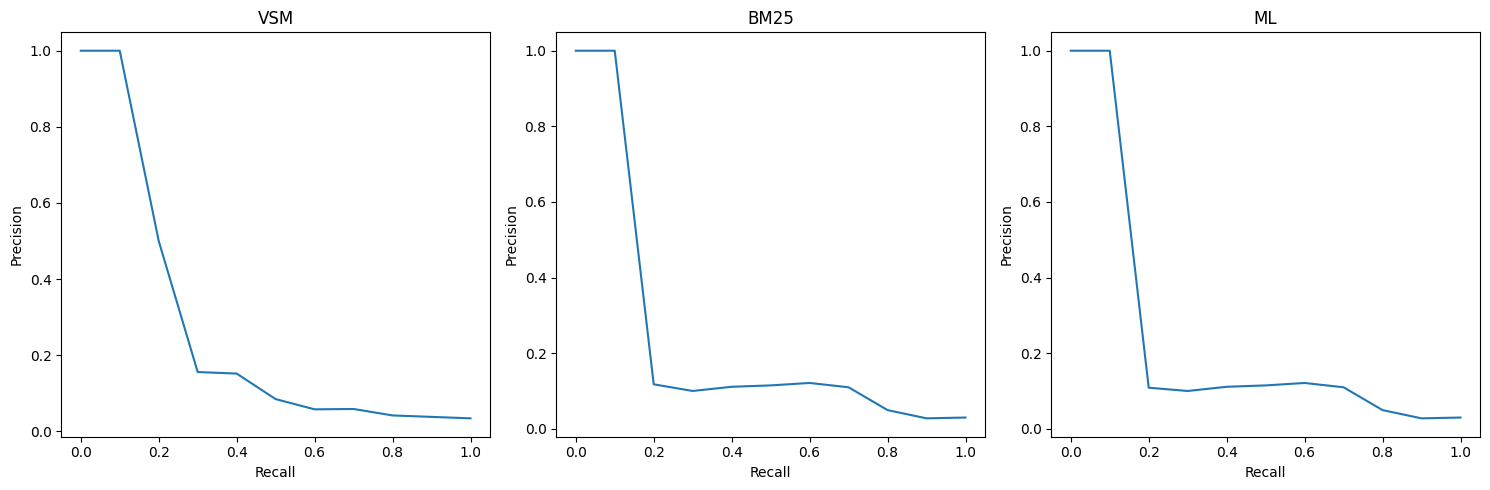

In [157]:
print("Results for different approaches of the 1st query:")
interpolated_average_precision_plotter(1, N, tf_idf_matrix)

As it it obviuos from the above picture, in 11-point interpolation average precision, recall and precision start from 0 and 1 respectively. As we go furthur, the recall always increases, but precision could be go up and down. But in general, it decreases. The sudden fall in the above pictures means that the most relevant documents have been returned and the rest of documents are not that much relevant. I mean during the time, the probsbility of the revalcy of a document to the query decreases.

Results for different approaches of the 2nd query:
11
11
11


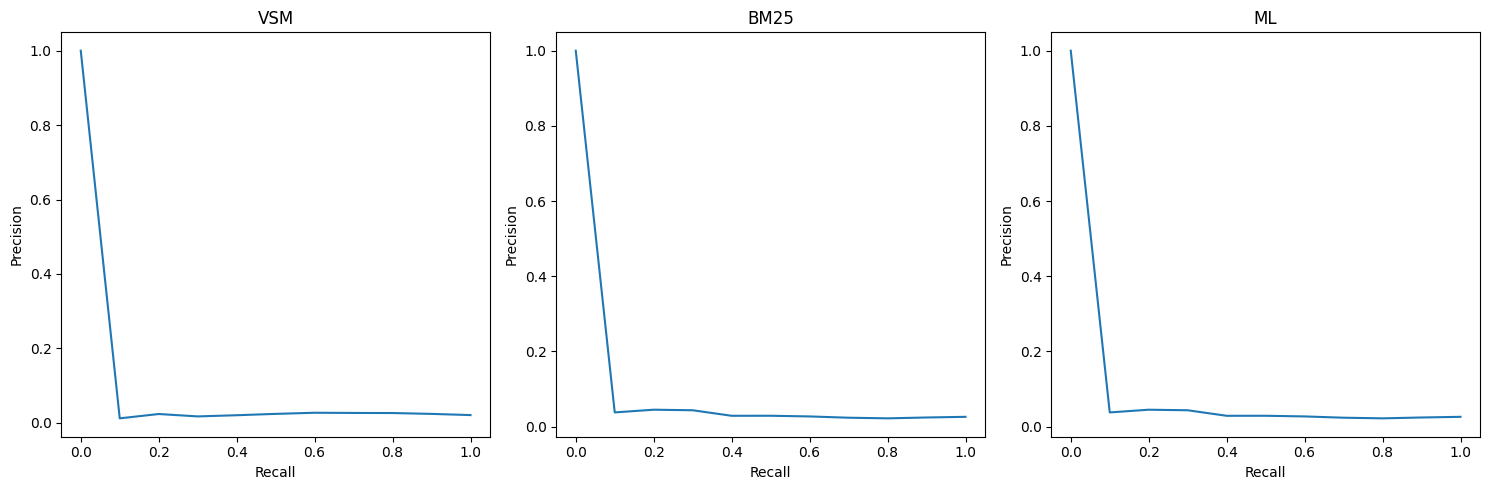

In [158]:
print("Results for different approaches of the 2nd query:")
interpolated_average_precision_plotter(2, N, tf_idf_matrix)

## Evaluate above approaches among queries

In the below, the precision of each approach is showed for fisrt 30 queries. The distribution is not uniform and slight and that;s because of the evaluation data which is provided in the dataset. It means that the labels that are given to the queries in the data set, not good enoght.

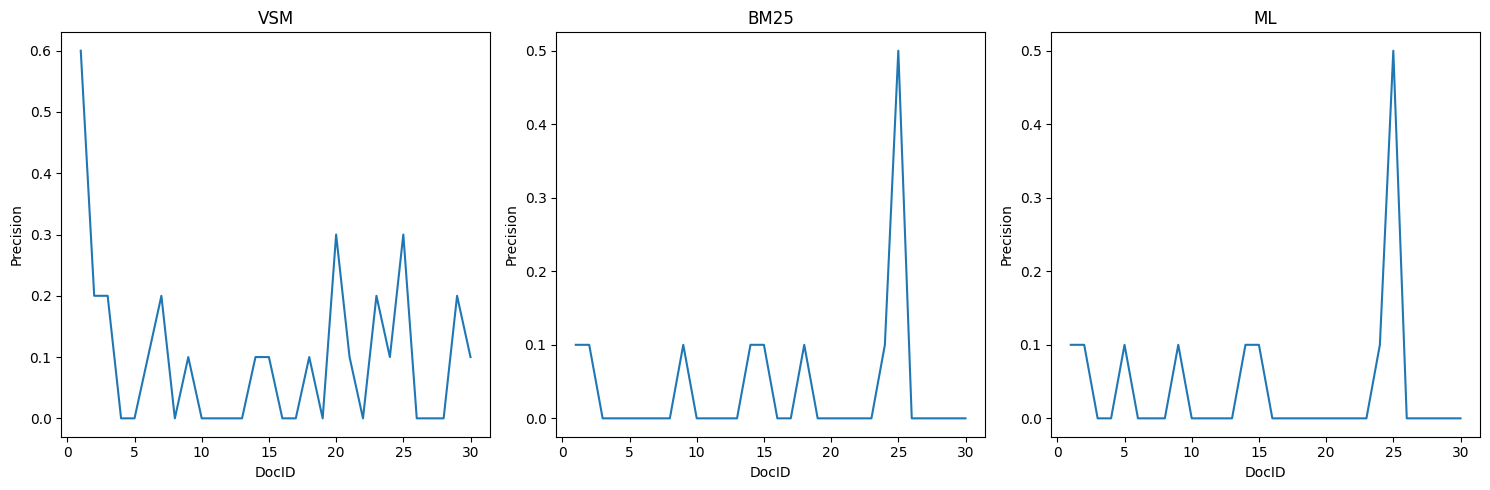

In [155]:
k = 10
precision1, x1 = [], []
precision2, x2 = [], []
precision3, x3 = [], []

# VSM
for i in range(30):
    top_k_documents = VSM_ranking(df_q['preprocessed_query'][i], k, tf_idf_matrix)
    result = []
    for j in range(k):
        result.append(top_k_documents[j][0]+1)
    precision1.append(compute_precision(evaluation_dict[i+1], result))
    x1.append(i+1)

# BM25
for i in range(30):
    top_k_documents = BM25_ranking(df_q['preprocessed_query'][i], k, tf_idf_matrix)
    result = []
    for j in range(k):
        result.append(top_k_documents[j][0]+1)
    precision2.append(compute_precision(evaluation_dict[i+1], result))
    x2.append(i+1)

# ML
for i in range(30):
    top_k_documents = ML_ranking(df_q['preprocessed_query'][i], k, .2)
    result = []
    for j in range(k):
        result.append(top_k_documents[j][0]+1)
    precision3.append(compute_precision(evaluation_dict[i+1], result))
    x3.append(i+1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(x1, precision1)
axs[0].set_title('VSM')
axs[0].set_xlabel("DocID")
axs[0].set_ylabel("Precision")

axs[1].plot(x2, precision2)
axs[1].set_title('BM25')
axs[1].set_xlabel("DocID")
axs[1].set_ylabel("Precision")

axs[2].plot(x3, precision3)
axs[2].set_title('ML')
axs[2].set_xlabel("DocID")
axs[2].set_ylabel("Precision")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## Compere Document Ranking Models

As it is obvious from tha last plot, the maen precision for fisrt 30 queries in VSM is more that BM25 and ML. It means that in Cranfield dataset, the VSM approuchs works better based of the labels which are given to the queries. Also, the plots of BM25 and ML in Fig.2 are mostly the same which means that these two apploaches work similarly on the Cranfield dataset.